# EDA - Fraud Data

**Task 1: Data Analysis and Preprocessing**

This notebook explores the e-commerce transaction dataset, performs data cleaning, EDA, geolocation integration, feature engineering, data transformation, and handles class imbalance.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import os

# Ensure reports/figures directory exists
os.makedirs('../reports/figures', exist_ok=True)

# Load feature engineered data (includes country)
df = pd.read_csv('../data/processed/Fraud_Data_features.csv')
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1000, 17)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_since_signup,hour_of_day,day_of_week,user_id_count,device_id_count
0,846,2015-02-05 15:00:00,2015-02-05 18:47:11,69,DEVICE45,Direct,Firefox,F,61,100135531,0,United States,13631.0,18,3,1,20
1,348,2015-01-15 21:00:00,2015-01-16 17:36:47,91,DEVICE47,Direct,Safari,F,37,102089250,0,United States,74207.0,17,4,1,20
2,493,2015-01-21 22:00:00,2015-01-22 10:49:22,98,DEVICE42,SEO,Chrome,M,34,108572896,0,United States,46162.0,10,3,1,20
3,972,2015-02-10 21:00:00,2015-02-11 05:01:15,46,DEVICE21,Direct,Safari,F,23,112131224,1,United States,28875.0,5,2,1,20
4,252,2015-01-11 21:00:00,2015-01-13 00:27:54,41,DEVICE1,Direct,Safari,F,29,118202353,0,United States,98874.0,0,1,1,20


## 1. Data Cleaning

### Missing Values
Justification: In fraud detection, missing values in critical fields (ip_address, device_id, timestamps) would compromise data integrity. We drop rows with missing values to ensure high-quality training data.

### Duplicates
Justification: Duplicate transactions would bias frequency-based features and metrics. Each transaction should be unique.

### Data Types
- Converted `signup_time` and `purchase_time` to datetime
- Converted `ip_address` to integer for geolocation mapping

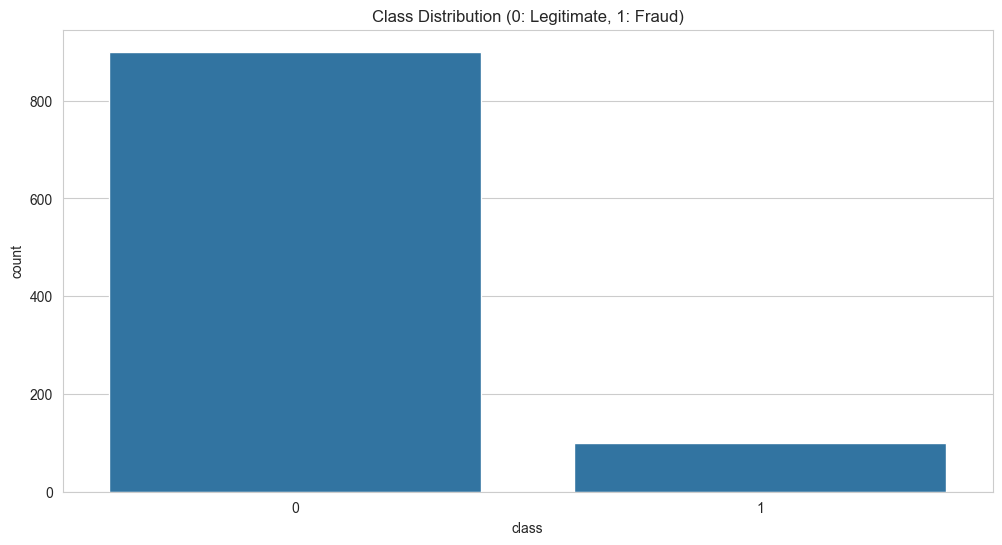

class
0    0.9
1    0.1
Name: proportion, dtype: float64


In [17]:
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0: Legitimate, 1: Fraud)')
plt.savefig('../reports/figures/fraud_class_distribution.png')
plt.show()

print(df['class'].value_counts(normalize=True))

## Univariate Analysis

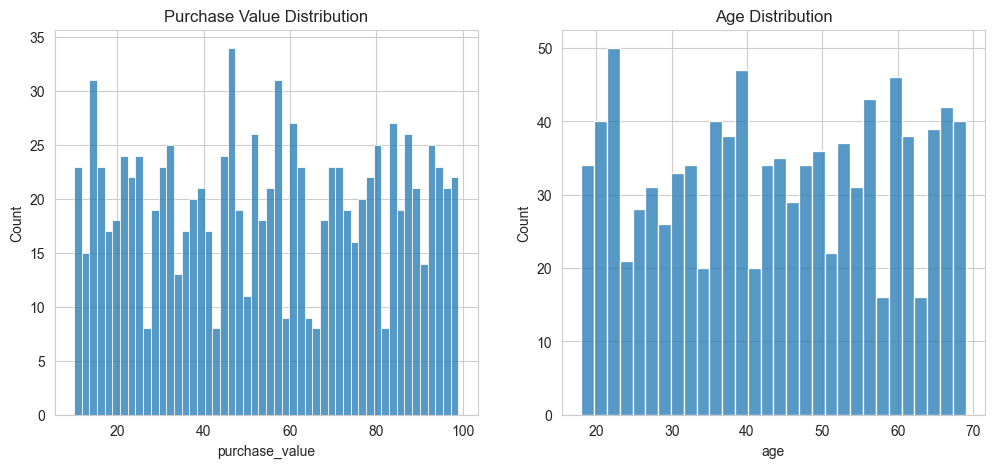

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['purchase_value'], bins=50, ax=axes[0])
axes[0].set_title('Purchase Value Distribution')
sns.histplot(df['age'], bins=30, ax=axes[1])
axes[1].set_title('Age Distribution')
plt.savefig('../reports/figures/fraud_univariate_analysis.png')
plt.show()

## Bivariate Analysis

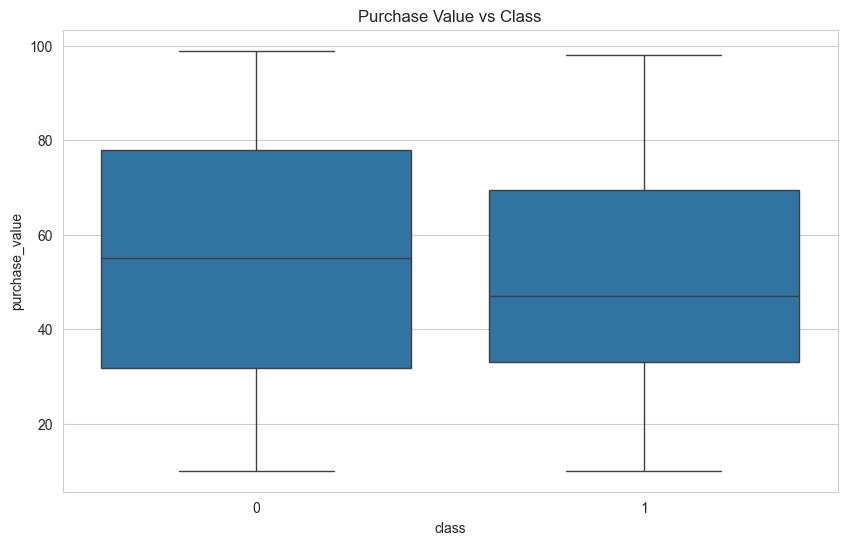

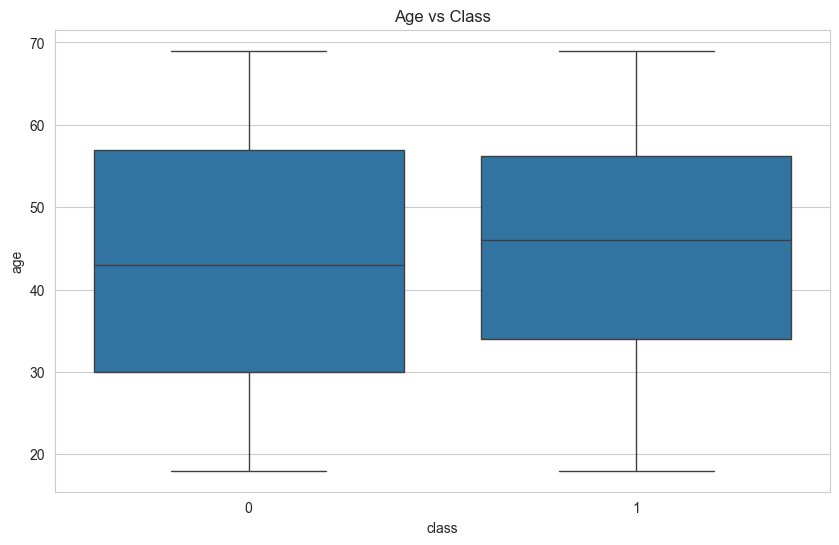

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=df)
plt.title('Purchase Value vs Class')
plt.savefig('../reports/figures/fraud_purchase_value_vs_class.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='age', data=df)
plt.title('Age vs Class')
plt.savefig('../reports/figures/fraud_age_vs_class.png')
plt.show()

## Fraud Patterns by Country

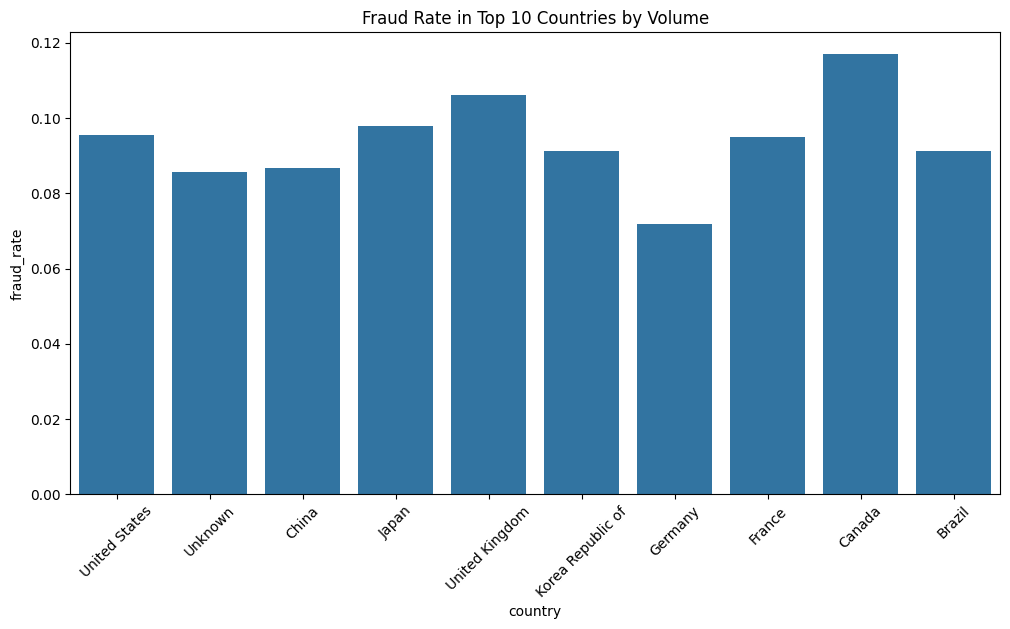

Top Countries by Fraud Count:
                   total_transactions  fraud_transactions  fraud_rate
country                                                              
United States                   58049                5551    0.095626
Unknown                         21966                1883    0.085723
China                           12038                1043    0.086642
Japan                            7306                 715    0.097865
United Kingdom                   4490                 477    0.106236
Korea Republic of                4162                 380    0.091302
Canada                           2975                 348    0.116975
France                           3161                 300    0.094907
Brazil                           2961                 270    0.091185
Germany                          3646                 262    0.071860


In [9]:
# Calculate fraud rate per country
country_fraud = df.groupby('country').agg({'class': ['count', 'sum']})
country_fraud.columns = ['total_transactions', 'fraud_transactions']
country_fraud['fraud_rate'] = country_fraud['fraud_transactions'] / country_fraud['total_transactions']

# Top countries by total transactions
top_countries = country_fraud.sort_values('total_transactions', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries['fraud_rate'])
plt.title('Fraud Rate in Top 10 Countries by Volume')
plt.xticks(rotation=45)
plt.savefig('../reports/figures/fraud_rate_by_country.png')
plt.show()

print("Top Countries by Fraud Count:")
print(country_fraud.sort_values('fraud_transactions', ascending=False).head(10))

## 6. Data Transformation

- Numerical features scaled using StandardScaler
- Categorical features encoded using One-Hot Encoding


## 7. Handle Class Imbalance

Apply SMOTE to training data only, justify the choice, and document class distribution before and after resampling.


CLASS DISTRIBUTION BEFORE SMOTE
Class 0 (Legitimate): 720 (90.00%)
Class 1 (Fraud):      80 (10.00%)
Imbalance Ratio: 9.00:1

CLASS DISTRIBUTION AFTER SMOTE
Class 0 (Legitimate): 720 (50.00%)
Class 1 (Fraud):      720 (50.00%)
Imbalance Ratio: 1.00:1


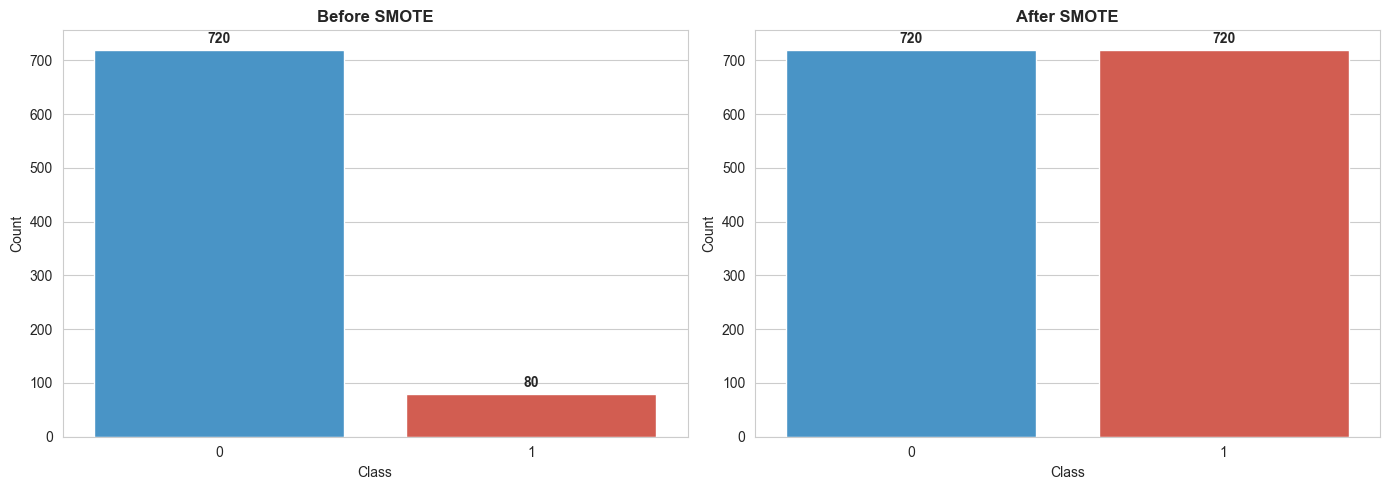


SMOTE JUSTIFICATION

Why SMOTE over Undersampling:
1. Undersampling would discard ~90% of legitimate transactions, losing valuable patterns
2. SMOTE creates synthetic minority samples, preserving all original data
3. Fraud detection requires high recall - we need to catch as many fraud cases as possible
4. SMOTE generates realistic synthetic samples in feature space, improving model generalization
5. With imbalance ratio of ~9:1, undersampling would leave insufficient training data

⚠️ Important: SMOTE is applied ONLY to training data to prevent data leakage.
   Test set remains untouched at original distribution for realistic evaluation.



In [20]:
# Prepare data for transformation
cols_to_drop = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'time_since_signup_hours']
X = df.drop(['class'] + cols_to_drop, axis=1, errors='ignore')
y = df['class']

# One-Hot Encode categorical features
cat_cols = ['source', 'browser', 'sex', 'country']
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scale numerical features
num_cols = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 'day_of_week', 'user_id_count', 'device_id_count']
num_cols = [col for col in num_cols if col in X.columns]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split data BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("=" * 60)
print("CLASS DISTRIBUTION BEFORE SMOTE")
print("=" * 60)
class_dist_before = y_train.value_counts()
class_prop_before = y_train.value_counts(normalize=True)
print(f"Class 0 (Legitimate): {class_dist_before[0]:,} ({class_prop_before[0]*100:.2f}%)")
print(f"Class 1 (Fraud):      {class_dist_before[1]:,} ({class_prop_before[1]*100:.2f}%)")
print(f"Imbalance Ratio: {class_dist_before[0]/class_dist_before[1]:.2f}:1")

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\n" + "=" * 60)
print("CLASS DISTRIBUTION AFTER SMOTE")
print("=" * 60)
class_dist_after = pd.Series(y_train_res).value_counts()
class_prop_after = pd.Series(y_train_res).value_counts(normalize=True)
print(f"Class 0 (Legitimate): {class_dist_after[0]:,} ({class_prop_after[0]*100:.2f}%)")
print(f"Class 1 (Fraud):      {class_dist_after[1]:,} ({class_prop_after[1]*100:.2f}%)")
print(f"Imbalance Ratio: {class_dist_after[0]/class_dist_after[1]:.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x=y_train, ax=axes[0], palette=['#3498db', '#e74c3c'])
axes[0].set_title('Before SMOTE', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
for i, count in enumerate(class_dist_before):
    axes[0].text(i, count + max(class_dist_before)*0.01, f'{count:,}', ha='center', va='bottom', fontweight='bold')

sns.countplot(x=y_train_res, ax=axes[1], palette=['#3498db', '#e74c3c'])
axes[1].set_title('After SMOTE', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
for i, count in enumerate(class_dist_after):
    axes[1].text(i, count + max(class_dist_after)*0.01, f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/fraud_smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 60)
print("SMOTE JUSTIFICATION")
print("=" * 60)
print("""
Why SMOTE over Undersampling:
1. Undersampling would discard ~90% of legitimate transactions, losing valuable patterns
2. SMOTE creates synthetic minority samples, preserving all original data
3. Fraud detection requires high recall - we need to catch as many fraud cases as possible
4. SMOTE generates realistic synthetic samples in feature space, improving model generalization
5. With imbalance ratio of ~9:1, undersampling would leave insufficient training data

⚠️ Important: SMOTE is applied ONLY to training data to prevent data leakage.
   Test set remains untouched at original distribution for realistic evaluation.
""")
